In [1]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

In [44]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

Files already downloaded and verified


In [175]:
loss_function = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [164]:
device = torch.device('cpu')

def real_data_target(size):
    return (torch.ones(size, 1, 3, 3)).to(device)

def fake_data_target(size):
    return (torch.zeros(size, 1, 3, 3)).to(device)

In [182]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #ENCODER
        
        self.convE1 = nn.Conv2d(1, 64, kernel_size = (3, 3), stride = 2, padding = 1)#32x32
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1)#16x16
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.convE3 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 2, padding = 1)#8x8
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.convE4 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 2, padding = 1)#4x4
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.convE5 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 2, padding = 1)#2x2
        self.batch_norm5 = nn.BatchNorm2d(512)      
        
        #DECODER
        
        self.convT1 = nn.ConvTranspose2d(512, 512, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.convT2 = nn.ConvTranspose2d(1024, 256, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm7 = nn.BatchNorm2d(256)
        self.convT3 = nn.ConvTranspose2d(512, 128, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm8 = nn.BatchNorm2d(128)
        self.convT4 = nn.ConvTranspose2d(256, 64, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm9 = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(128, 2, kernel_size = (4, 4), stride = 2, padding = 1)
        
        
    def forward(self, x):
        
        
        #ENCODER
        
        x1 = F.leaky_relu(self.convE1(x))#16x16x64
        x1 = self.batch_norm1(x1)
        x1_concat = F.leaky_relu(self.convE2(x1))#8x8x128
        x1_concat = self.batch_norm2(x1_concat)
        x2 = F.leaky_relu(self.convE3(x1_concat))#4x4x256
        x2 = self.batch_norm3(x2)
        x2_concat = F.leaky_relu(self.convE4(x2))#2x2x512
        x2_concat = self.batch_norm4(x2_concat)
        x3 = F.leaky_relu(self.convE5(x2_concat))#1x1x512
        
        #DECODER
        
        x5 = self.convT1(x3)#2x2x512
        x5 = self.batch_norm6(x5)
        x5 = torch.cat((x5, x2_concat), 1)#2x2x1024
        x5 = self.convT2(x5)#4x4x512
        x5 = self.batch_norm7(x5)
        x5 = torch.cat((x5, x2), 1)#512
        x5 = self.convT3(x5)#8x8x128
        x5 = self.batch_norm8(x5)
        x5 = torch.cat((x5, x1_concat), 1)#8x8x256
        x5 = self.convT4(x5)#16x16x64
        x5 = self.batch_norm9(x5)
        x5 = torch.cat((x5, x1), 1)#16x16x128
        x5 = self.convT5(x5)#32x32x2
        
        return x5

generator = Generator()
generator.to(device)

Generator(
  (convE1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm6)

In [136]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #ENCODER
        
        self.convE1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = 2, padding = 0)#16x16
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 0)#8x8
        self.convE3 = nn.Conv2d(128, 1, kernel_size = (3, 3), stride = 2, padding = 0)#4x4
        
        
    def forward(self, x):
        
        x1 = F.leaky_relu(self.convE1(x))
        x2 = F.leaky_relu(self.convE2(x1))
        x3 = torch.sigmoid(self.convE3(x2))        
        
        
        return x3

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (convE1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (convE3): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [183]:
for w in train_batch:
    break
m = generator.forward(z)
print(m.size())
n = discriminator.forward(torch.randn([1,3,32,32]))
print(np.shape(n))

torch.Size([1, 2, 32, 32])
torch.Size([1, 1, 3, 3])


In [176]:
def train_generator(fake_image):
    optimizer_generator.zero_grad()
    #target image has 2 channels
    target = torch.randn([1,2,32,32])
    fake_image_d = torch.cat((fake_image, torch.randn([1,1,32,32])), 1)
    prediction_fake_image = discriminator.forward(fake_image_d)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    l1_loss = abs(fake_image - target)
    total_gen_loss = loss_fake_image + (100 * l1_loss)
    loss_fake_image.backward()
    optimizer_generator.step()
    
    return loss_fake_image

f = train_generator(torch.randn([1,2,32,32]))

In [177]:
def train_discriminator(real_image, fake_image):
    optimizer_discriminator.zero_grad()
    
    #training discriminator using real images
    prediction_real = discriminator.forward(real_image)
    loss_real_image = loss_function(prediction_real, real_data_target(prediction_real.size(0)))
    loss_real_image.backward()
    
    #training discriminator using fake image
    fake_image_d = torch.cat((fake_image, torch.randn([1,1,32,32])), 1)
    prediction_fake = discriminator.forward(fake_image_d)
    loss_fake_image = loss_function(prediction_fake, fake_data_target(prediction_fake.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real, prediction_fake

d1, d2, d3 = train_discriminator(torch.randn([1,3,32,32]), torch.randn([1,2,32,32]))

In [215]:
#utils.save_image(torch.tensor(w[0][0]), os.path.join('pyTorch_cifar10' ,str(1)+'.png'))
#temp = cv2.imread(os.path.join('pyTorch_cifar10' ,str(1)+'.png'))
temp = cv2.imread('Places365_val_00000001.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2LAB)
l, a, b = cv2.split(temp)
#L_images_batch = np.zeros([500,100,1,32,32])
# L_images_batch[i][j] = l
# temp = np.transpose(temp, (2,0,1)) 
# LAB_images_batch[i][j] = temp

In [216]:
np.shape(w[0][0])

torch.Size([3, 32, 32])

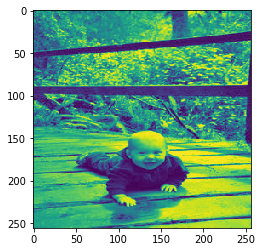

In [222]:
plt.imshow(l)

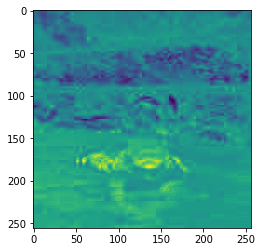

In [223]:
plt.imshow(a)

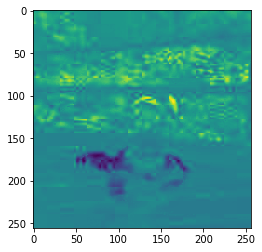

In [224]:
plt.imshow(b)

In [225]:
cv2.imwrite('filename.jpg', temp) 

True